In [2]:
import pandas as pd
from darts import TimeSeries
from darts.models import TFTModel
from darts.metrics import mae
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from itertools import product
import matplotlib.pyplot as plt
import torch
print(torch.cuda.is_available())

c:\Users\Stijn\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


False


c:\Users\Stijn\AppData\Local\Programs\Python\Python310\lib\site-packages\statsforecast\utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


In [3]:
# Load your data into a DataFrame
data = pd.read_csv('merged_data.csv')
data['DateTime'] = pd.to_datetime(data['DateTime'])

In [4]:
# Convert the DataFrame to a TimeSeries instance
series = TimeSeries.from_dataframe(data, 'DateTime', 'MeanEnergyConsumption')

In [5]:
# Split the data into a training set and a validation set
train, val = series.split_before(pd.Timestamp('2014-02-21'))

In [6]:
# Normalize the time series
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)

In [7]:
# Create covariates
covariates = datetime_attribute_timeseries(series, attribute='month', one_hot=True)
covariates = covariates.stack(datetime_attribute_timeseries(series, attribute='day', one_hot=True))

In [8]:
# Normalize the covariates
transformer_cov = Scaler()
covariates_transformed = transformer_cov.fit_transform(covariates)

In [9]:
# Define the parameter grid
param_grid = {
    'input_chunk_length': [12, 24, 48],
    'output_chunk_length': [1, 7, 14],
    'hidden_size': [16, 32, 64]
}

# Initialize the best parameters and the best score
best_params = None
best_score = float('inf')

# Generate all combinations of parameters
param_combinations = list(product(*param_grid.values()))

In [10]:

from multiprocessing import Pool

def evaluate_params(params):
    params_dict = dict(zip(param_grid.keys(), params))
    model = TFTModel(n_epochs=10, **params_dict)
    model.fit(train_transformed, future_covariates=covariates_transformed, verbose=True)
    forecast = model.predict(n=7, future_covariates=covariates_transformed)
    score = mae(forecast, val_transformed)
    return score, params_dict

if __name__ == '__main__':
    with Pool() as pool:
        results = pool.map(evaluate_params, param_combinations)

    # Find the best score and parameters
    best_score, best_params = min(results, key=lambda x: x[0])

    print('Best parameters: ', best_params)
    print('Best score: ', best_score)

In [10]:

# Set the precision for float32 matrix multiplication
torch.set_float32_matmul_precision('medium')

# Create and train the TFT model
model = TFTModel(input_chunk_length=30, output_chunk_length=7, n_epochs=25)
model.fit(train_transformed, future_covariates=covariates_transformed, verbose=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 31.1 K
5  | decoder_vsn                       | _VariableSelectionNetwork        | 30.4 K
6  | static_context_grn                | _GatedResidualNetwork            | 1.1 K 
7  | static_context_hidden_encoder_grn | _GatedResidualNetwork            | 1.1 K 
8  | static_cont

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


TFTModel(output_chunk_shift=0, hidden_size=16, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=30, output_chunk_length=7, n_epochs=25)

In [ ]:
# Generate a forecast
forecast = model.predict(n=48*7, future_covariates=covariates_transformed)

ValueError: For the given forecasting horizon `n=336`, the provided future covariates at dataset index `0` do not extend far enough into the future. As `n > output_chunk_length` the future covariates must end at time step `2014-03-06 23:00:00`, whereas now they end at time step `2014-02-28 00:00:00`.


ValueError: For the given forecasting horizon `n=336`, the provided future covariates at dataset index `0` do not extend far enough into the future. As `n > output_chunk_length` the future covariates must end at time step `2014-03-06 23:00:00`, whereas now they end at time step `2014-02-28 00:00:00`.

In [ ]:
# # Convert the normalized data back to the original scale
# original_unscaled = transformer.inverse_transform(train_transformed)

# Slice the original data to include only the time period covered by the forecast
original_slice = series.slice(forecast.start_time(), forecast.end_time())

# Inverse transform the forecast
forecast_unscaled = transformer.inverse_transform(forecast)

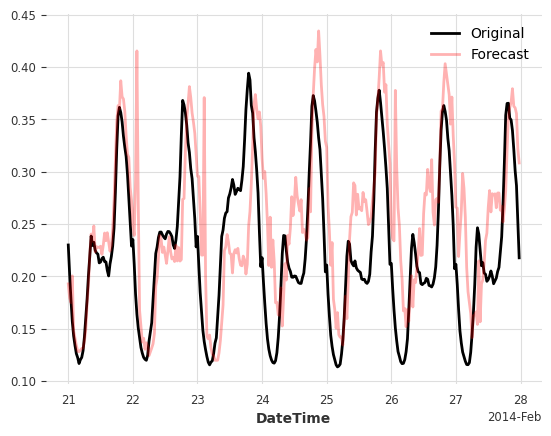

In [ ]:
# Plot the forecast
original_slice.plot(label='Original')
forecast_unscaled.plot(label='Forecast', alpha=0.3, color='red')
plt.legend()
plt.show()

39727
336


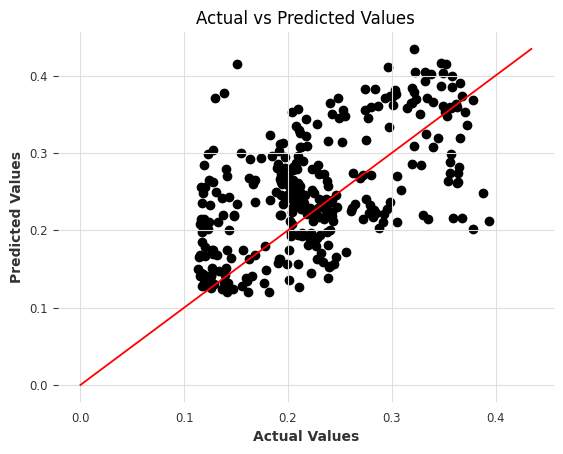

In [ ]:
# Create a scatter plot
length = len(series['MeanEnergyConsumption'])
print(length)
print(len(forecast_unscaled))

diff = length - len(forecast_unscaled)
#copy df to a new dataframe that drops the first row
df_new = series[diff:]


# Convert the TimeSeries to a DataFrame
forecast_df = forecast_unscaled.pd_dataframe()

# Convert the DataFrame to a 1-dimensional sequence
forecast_values = forecast_df.values.flatten()

# Convert 'MeanEnergyConsumption' to a 1-dimensional sequence
actual_values = df_new.values().flatten()

plt.scatter(actual_values, forecast_values)

# Create a 45 degree line
max_value = max(max(actual_values), max(forecast_values))
plt.plot([0, max_value], [0, max_value], color='red')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')

plt.show()